In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import os

while "notebooks" in os.getcwd():
    os.chdir("..")

import scienceplots
from time import time
from tqdm import tqdm
import torch
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset
import math
from typing import List, Optional, Tuple, Union
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import warnings
from bert_score import BERTScorer
warnings.filterwarnings("ignore")
from copy import deepcopy
from openai import OpenAI

from src.utils import rotate_half, apply_rotary_pos_emb, repeat_kv, \
    get_context_length, get_generated_text, FileReader, is_text_in_language, rolling_mean,\
    get_start_of_generation_token

from src.attention_saver import GUIDEModel


# plt.rc('font', family='serif')
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')
plt.style.use(['science','no-latex'])

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    cache_dir = "/Data"    
)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

df = load_dataset("stas/openwebtext-10k", cache_dir= "/Data")['train'].to_pandas()
df["text_len"] = df["text"].apply(lambda x: len(x.split(" ")))

In [6]:
base_instruction = "Summarize in french"
df["context_length"] = (base_instruction + " \n" + df["text"])\
    .apply(get_context_length, tokenizer = tokenizer)

In [7]:
base_path = "data/gemma-2-2b-it/checkpoints"
all_results = []

start_of_generation_token = get_start_of_generation_token("gemma")
for delta_attention in tqdm([0., 0.5, 1., 2.0,5.0, '0.0_upper_6k']):
        path = os.path.join(
            base_path,
            f"all_layers_generated_delta={delta_attention}.pkl"
        )
        try:
            results_df = pd.read_pickle(path).T

        except Exception as e:
            print(e)
            continue

        parsed_results_dict = dict()

        for epoch in range(len(results_df.columns)-1):
            for (idx, result_epoch) in results_df.loc[:,f"epoch {epoch}"].items():
                s = pd.Series(result_epoch)\
                    .apply(get_generated_text, start_of_generation_token= start_of_generation_token)\

                data = pd.DataFrame(s).T
                data.index = [idx]

                if not epoch in parsed_results_dict:
                    parsed_results_dict[epoch] = []

                parsed_results_dict[epoch].append(data)

            parsed_results_dict[epoch] = pd.concat(parsed_results_dict[epoch])

        all_dfs = []

        for epoch in parsed_results_dict.keys():
            temp_df = pd.melt(
                parsed_results_dict[epoch].reset_index(),
                var_name = "instruction",
                value_name = "generated_text",
                id_vars = "index",
            )

            temp_df["is_french"] = temp_df["generated_text"].apply(is_text_in_language)

            temp_df["generation_epoch"] = epoch

            all_dfs.append(temp_df)

        melted_df = pd.concat(all_dfs)

        melted_df = pd.merge(
            melted_df,
            df[["context_length", "text"]],
            left_on="index",
            right_index=True
        )

        melted_df["context_length_bins"] = pd.cut(
            melted_df["context_length"], 
            np.arange(0,6_500,1000)
        )

        melted_df.dropna(inplace=True)

        study_name = f"$\Delta$={delta_attention}"
            
        melted_df["study"] = study_name
        
        if delta_attention ==0:
            melted_df["study"] = f"Raw model"

        all_results.append(melted_df)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:43<00:00,  7.29s/it]


In [8]:
all_results_df = pd.concat(all_results).reset_index(drop = True)

In [9]:
x = all_results_df.query('instruction == "IMPORTANT: SUMMARIZE IN FRENCH: "')
x['study'] = "`Important' + uppercase"

y = all_results_df.query('instruction == "SUMMARIZE IN FRENCH: "')
y['study'] = "`Important' + uppercase"

In [10]:
all_results_df

,index,instruction,generated_text,is_french,generation_epoch,context_length,text,context_length_bins,study
0,2522,Summarize in french:,\nThis is a description and information about ...,False,0,5011,Book 1 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 1...,"(5000, 6000]",Raw model
1,6986,Summarize in french:,\nHere's a summary of the main points of the t...,False,0,5571,Seven billion people and growing. A quarter of...,"(5000, 6000]",Raw model
2,8385,Summarize in french:,\n## Summary of Spacefest V: A Celebration of...,False,0,5594,Recollections of Spacefest V\n\n“The past is p...,"(5000, 6000]",Raw model
3,3125,Summarize in french:,\nThis is a great transcript of the interview ...,False,0,5203,We are pleased to announce the launch of E-Lea...,"(5000, 6000]",Raw model
4,5100,Summarize in french:,"\nThis is a well-written, well-researched and ...",False,0,5428,"When she was found dead at 41, Carole Myers le...","(5000, 6000]",Raw model
...,...,...,...,...,...,...,...,...,...
20295,4775,IMPORTANT: SUMMARIZE IN FRENCH:,\nThis is a comprehensive and engaging piece a...,False,9,5489,written by Jennifer Warnick Unique Microsoft h...,"(5000, 6000]",$\Delta$=0.0_upper_6k
20296,3175,IMPORTANT: SUMMARIZE IN FRENCH:,\nThis is a very detailed and captivating acco...,False,9,5607,"On 24 July 1908, the final day of athletics at...","(5000, 6000]",$\Delta$=0.0_upper_6k
20297,7478,IMPORTANT: SUMMARIZE IN FRENCH:,\nThis is a great translation of the book by T...,False,9,5878,Does he get the linguistics right? That’s the ...,"(5000, 6000]",$\Delta$=0.0_upper_6k
20298,1845,IMPORTANT: SUMMARIZE IN FRENCH:,\nHere is a very good summary of the French te...,False,9,5655,"Fifteenth Street NW, heading south toward R St...","(5000, 6000]",$\Delta$=0.0_upper_6k


In [11]:
raw_instruction_df = all_results_df.query("instruction == 'Summarize in french: '")

uppercase_df = all_results_df.query(f"instruction == '{'Summarize in french: '.upper()}' & study == 'Raw model'")
uppercase_df['study'] = 'Uppercase'



In [12]:
raw_instruction_df.query("study == '$\Delta$=2.0'")


,index,instruction,generated_text,is_french,generation_epoch,context_length,text,context_length_bins,study
12000,2522,Summarize in french:,\nThis is a fascinating description of the boo...,False,0,5011,Book 1 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 1...,"(5000, 6000]",$\Delta$=2.0
12001,6986,Summarize in french:,\nVoici un résumé des 7 solutions abordées pou...,False,0,5571,Seven billion people and growing. A quarter of...,"(5000, 6000]",$\Delta$=2.0
12002,8385,Summarize in french:,\nVoici le résumé du récit d'un article de Roc...,False,0,5594,Recollections of Spacefest V\n\n“The past is p...,"(5000, 6000]",$\Delta$=2.0
12003,3125,Summarize in french:,\nCe podcast a abordé les défis auxquels les p...,True,0,5203,We are pleased to announce the launch of E-Lea...,"(5000, 6000]",$\Delta$=2.0
12004,5100,Summarize in french:,\n## Summary of the French text about Carole's...,False,0,5428,"When she was found dead at 41, Carole Myers le...","(5000, 6000]",$\Delta$=2.0
...,...,...,...,...,...,...,...,...,...
15795,4189,Summarize in french:,"\nAndrew Hozier-Byrne, connu sous le nom de Ho...",True,9,301,"Andrew Hozier-Byrne's voice is so rich, so vit...","(0, 1000]",$\Delta$=2.0
15796,1736,Summarize in french:,"\nMitch Robinson, autrefois connu pour ses pro...",True,9,306,REBORN footballer Mitch Robinson continues to ...,"(0, 1000]",$\Delta$=2.0
15797,3910,Summarize in french:,\nMauricio Pellegrino a terminé la session d'e...,True,9,242,Mauricio Pellegrino has been overseeing Saints...,"(0, 1000]",$\Delta$=2.0
15798,5952,Summarize in french:,\nLes prisonniers d'une prison de l'Ohio ont é...,True,9,258,"Story highlights Inmates built, transported an...","(0, 1000]",$\Delta$=2.0


In [13]:
results_raw_df = (raw_instruction_df)\
    .groupby(["context_length_bins", "study"])\
    .is_french\
    .mean()\
    .reset_index()

results_raw_df = results_raw_df.replace("Raw model", "Raw prompt")

results_upper_df = uppercase_df\
    .groupby(["context_length_bins", "study"])\
    .is_french\
    .mean()\
    .reset_index()

performance_per_index_per_instruction = pd.concat([
    results_raw_df,
    results_upper_df
])

In [14]:
hue_order = ['Raw prompt', 'Uppercase', '$\\Delta$=0.5', '$\\Delta$=1.0', '$\\Delta$=2.0']

In [15]:
palette = {
    'Raw prompt': sns.color_palette("Blues", 5)[2],    # Darker Blue
    'Uppercase': sns.color_palette("Blues", 5)[3],    # Medium Blue
    # "`Important' + uppercase": sns.color_palette("Blues", 5)[4],    # Medium Blue
    '$\\Delta$=0.5': sns.color_palette("Reds", 5)[1],        # Light Red
    '$\\Delta$=1.0': sns.color_palette("Reds", 5)[2],        # Medium Red
    '$\\Delta$=2.0': sns.color_palette("Reds", 5)[3],        # Darker Red
    '$\\Delta$=5.0': sns.color_palette("Reds", 5)[4]         # Darkest Red
}

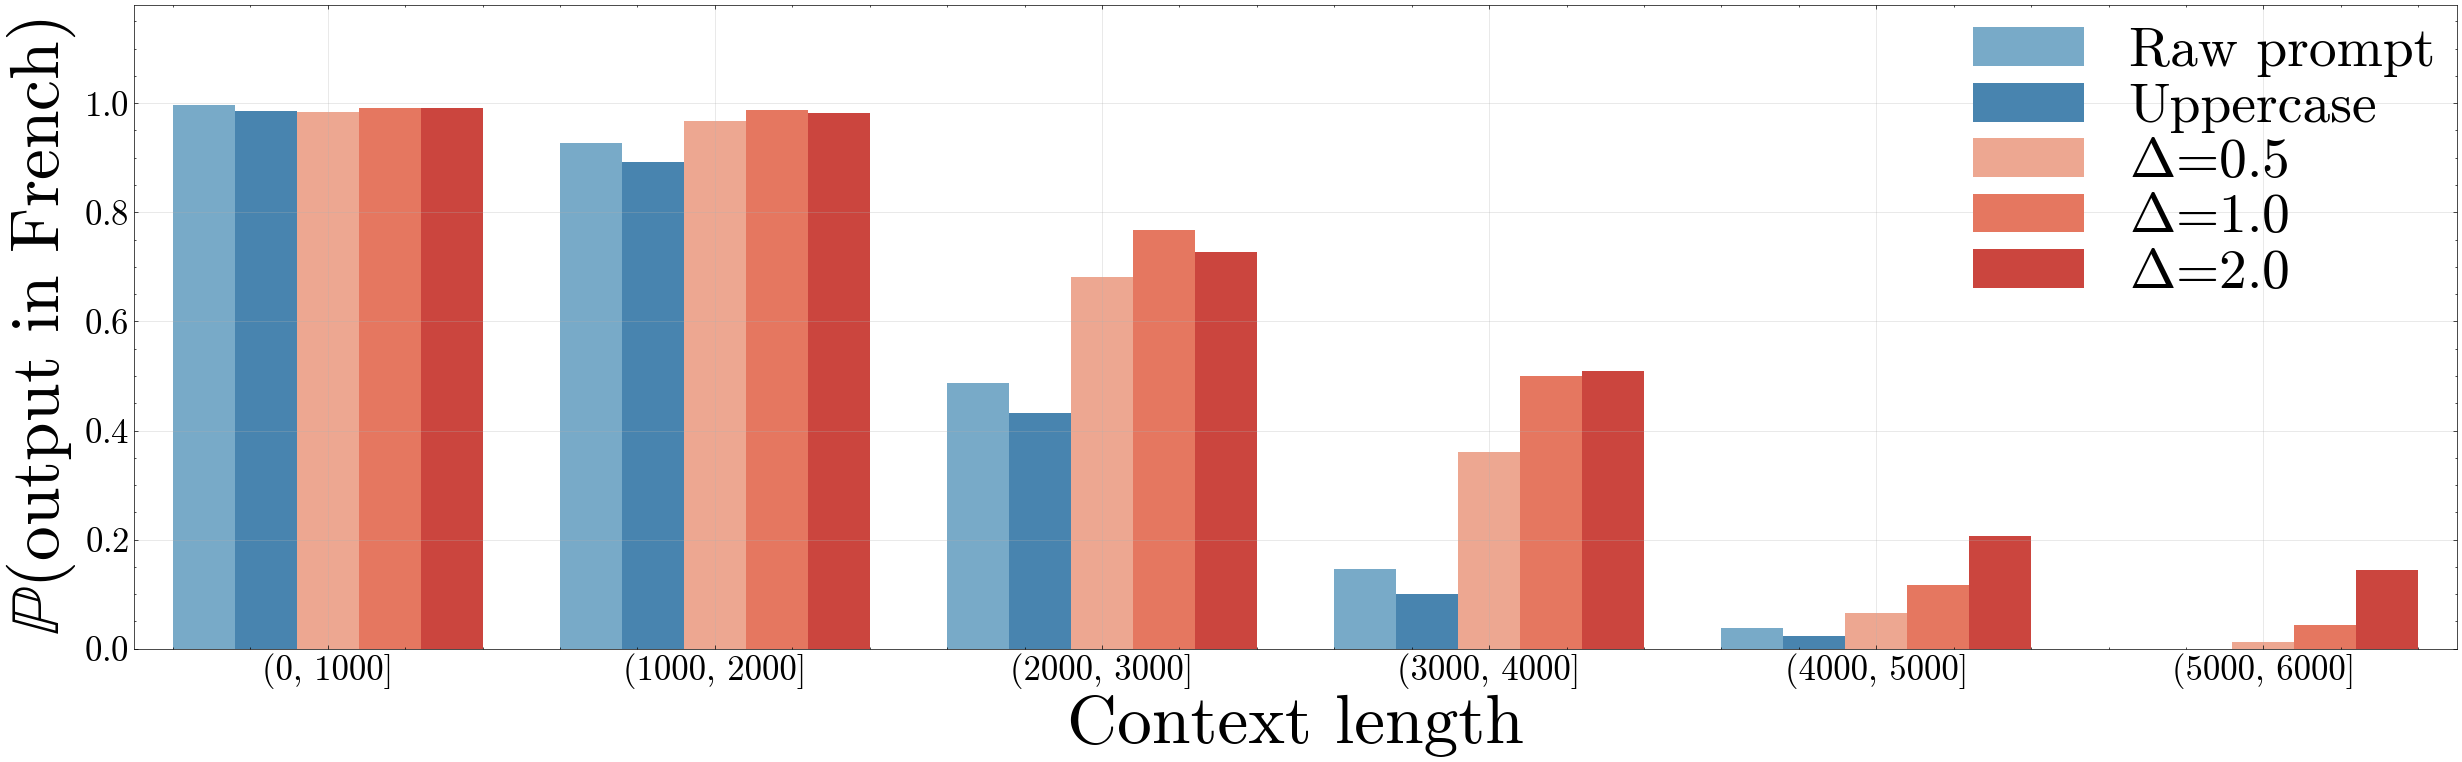

In [16]:
# performance_per_index_per_instruction = (all_results_df)\
#     .groupby(["context_length_bins", "study"])\
#     .is_french\
#     .mean()\
#     .reset_index()

plt.figure(figsize = (25,8))
plt.rc("font", size = 16)
ax = sns.barplot(
    performance_per_index_per_instruction,
    y = "is_french",
    x = "context_length_bins",
    hue = "study",
    hue_order= hue_order,
    # palette = 'tab10'
    palette= palette,
    ci = False
)

plt.grid(alpha = 0.4,)

label_fontsize = 50
legend_fontsize = 40
tick_fontsize = 25

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.legend(prop= {"size" : legend_fontsize})

# plt.xlim([-.5, 8.5])
plt.ylim([0, 1.18])
plt.subplots_adjust(top = 0.99)
plt.ylabel(r"$\mathbb{P}(\text{output in French})$", fontsize = label_fontsize)
plt.xlabel("Context length", fontsize = label_fontsize)
sns.move_legend(ax, labelspacing=0.1, loc='best', prop= {"size" : legend_fontsize}, borderaxespad=0.)
plt.tight_layout()
plt.savefig("img/attention vs delta_gemma2.pdf")
plt.show()

In [31]:
performance_per_index_per_instruction.groupby("study")\
    .is_french\
    .mean()

study
$\Delta$=0.5    0.514369
$\Delta$=1.0    0.570551
$\Delta$=2.0    0.597635
$\Delta$=5.0    0.002427
Raw prompt      0.433687
Uppercase       0.407909
Name: is_french, dtype: float64

In [14]:
base_path = "data/generated_text_llm"

targets= dict()

for model_name in os.listdir(base_path):

    path = os.path.join(base_path, model_name, "generated_text_llm.pkl")

    try:
        df = pd.read_pickle(path)
    except:
        continue

    targets[model_name] = df

In [15]:
targets_df = pd.concat(targets.values())\
    .rename(columns = {"generated_text":"target"})

In [16]:
targets_df

,target,text,text_idx
0,Voici un résumé en français du texte sur la pa...,The partition of Quebec refers to the secessio...,134
1,Voici un résumé en français du texte :\n\n« To...,Everything you know about ARGs is WRONG 22 Dec...,9341
2,Voici un résumé en français du texte original ...,Cyrstal Meth Addiction\n\nCrystal meth addicti...,2973
3,Voici un résumé en français du texte :\n\nLe m...,Quảng Đức is descriptive of meritorious attrib...,8280
4,Voici un résumé de l'article en français :\n\n...,"World Electioneering Entertainment 2016: 1,000...",3921
...,...,...,...
235,Voici un résumé du texte en français :\n\nUne ...,A New Zealand firm says it successfully triall...,7394
236,Voici un résumé du texte en français :\n\nFaiz...,Originally Posted by Faizan Lakhani Originally...,6932
237,Voici un résumé du texte en français :\n\nÀ Da...,"DAVAO CITY, Philippines — Residents who are 18...",3943
238,LORSQUE LA RHÉTORIQUE DE LA DROITE TOURNE À LA...,WHEN THE RIGHT’S RHETORIC TURNS VIOLENT…. In t...,4922


In [17]:
all_results_df

,index,instruction,generated_text,is_french,generation_epoch,context_length,text,context_length_bins,study
0,2522,Summarize in french:,\nThis is a description and information about ...,False,0,5011,Book 1 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 1...,"(5000, 5500]",Raw model
1,6986,Summarize in french:,\nHere's a summary of the main points of the t...,False,0,5571,Seven billion people and growing. A quarter of...,"(5500, 6000]",Raw model
2,8385,Summarize in french:,\n## Summary of Spacefest V: A Celebration of...,False,0,5594,Recollections of Spacefest V\n\n“The past is p...,"(5500, 6000]",Raw model
3,3125,Summarize in french:,\nThis is a great transcript of the interview ...,False,0,5203,We are pleased to announce the launch of E-Lea...,"(5000, 5500]",Raw model
4,5100,Summarize in french:,"\nThis is a well-written, well-researched and ...",False,0,5428,"When she was found dead at 41, Carole Myers le...","(5000, 5500]",Raw model
...,...,...,...,...,...,...,...,...,...
19995,4189,SUMMARIZE IN FRENCH:,\nLet's break down this passage about Hozier's...,False,9,301,"Andrew Hozier-Byrne's voice is so rich, so vit...","(0, 500]",$\Delta$=5.0
19996,1736,SUMMARIZE IN FRENCH:,\nThis is a sports article reporting on a Bris...,False,9,306,REBORN footballer Mitch Robinson continues to ...,"(0, 500]",$\Delta$=5.0
19997,3910,SUMMARIZE IN FRENCH:,"\nYou've provided a pretty good news piece, ri...",False,9,242,Mauricio Pellegrino has been overseeing Saints...,"(0, 500]",$\Delta$=5.0
19998,5952,SUMMARIZE IN FRENCH:,"\nThis is a text-based security alert, perhaps...",False,9,258,"Story highlights Inmates built, transported an...","(0, 500]",$\Delta$=5.0


In [18]:
complete_df = pd.merge(
    all_results_df,
    targets_df,
    left_on = "index",
    right_on = "text_idx"
)

In [19]:
scorer = BERTScorer(model_type = "almanach/camembert-base", num_layers = 12, device='cuda')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [20]:
tqdm.pandas()
p, r, f1 = scorer.score(
    complete_df['generated_text'].to_list(), 
    complete_df['target'].to_list(),
    batch_size = 128    
)



In [21]:
complete_df['bert-score'] = f1

In [22]:
complete_df.study.unique()

array(['Raw model', '$\\Delta$=0.5', '$\\Delta$=1.0', '$\\Delta$=2.0',
       '$\\Delta$=5.0'], dtype=object)

In [50]:
raw_model_performance = complete_df.query(f"study == 'Raw model' & is_french == 1")

In [52]:
# fig, axs = plt.subplots(2, 2, figsize=(16, 12))
study_winning_rates = dict()

for i, study_name in enumerate(complete_df.study.unique()):
    if study_name == 'Raw model':
        continue
    
    clear_output()
    print(f"comparing french text generated by {study_name} to raw model")

    winning_dict = dict()
    
    augmented_model_performance = complete_df.query(f"study == '{study_name}' & is_french == 1")
    print(len(augmented_model_performance))
    for idx, row in tqdm(augmented_model_performance.iterrows(), total = len(augmented_model_performance)):
        bert_scores = row['bert-score']
        text_idx = row['index']
        winning_dict[idx] = raw_model_performance.query(f"index == {text_idx}")['bert-score'] < bert_scores

    winning_rate_df = pd.DataFrame(winning_dict)
    winning_rate_df.index.name = "Raw model"
    winning_rate_df.columns.name = study_name

    study_winning_rates[study_name] = winning_rate_df

#     j = (i-1) // 2
#     k = (i-1) % 2
#     sns.heatmap(winning_rate_df, cmap='viridis' ,ax= axs[j][k])
#     axs[j][k].set_title(f"Winning matrix of sutdy : {study_name} - winning_rate = {round(winning_rate_df.mean().mean(),2)}")


# fig.subplots_adjust(hspace=0.3)

comparing french text generated by $\Delta$=5.0 to raw model
0


0it [00:00, ?it/s]


In [53]:
for study, winning_rate in study_winning_rates.items():
    study_winning_rates[study] = (winning_rate).sum().sum()/winning_rate.count(axis=0).sum()

In [54]:
study_winning_rates

{'$\\Delta$=0.5': 0.5346097201767305,
 '$\\Delta$=1.0': 0.46675031367628605,
 '$\\Delta$=2.0': 0.4509316770186335,
 '$\\Delta$=5.0': nan}